In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import os
import sqlalchemy
from sqlalchemy import create_engine
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
import alloc_functions.allocation_scenario as asf
import alloc_functions.controller as acf
import alloc_functions.daily as adf
import alloc_functions.cleanup as cleaner
import alloc_functions.mixed as mixed
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from pulp import *
fps_colours = ['#004A9C', '#45D281', '#FEC001','#A365E0', '#5B9BD5',

               '#FF0000', '#0563C1', '#954F72']
import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')


In [4]:
TIME_INT_IS = dt.timedelta(minutes=30)
N = int(dt.timedelta(days=1)/TIME_INT_IS)
POTENTIAL_TPS_IS = [i*TIME_INT_IS for i in range(N)]
TP_FRACT_IS = TIME_INT_IS/dt.timedelta(hours=1)
XMPG = 0.8
TURN = 5
def find_allocation(idx, cnx):
    try:
        sql_query = f"""SELECT * FROM t_allocation WHERE allocation_id={idx} LIMIT 1"""
        current_allocation = pd.read_sql_query(sql_query, cnx).iloc[0].to_dict()
    except (Exception, psycopg2.Error) as error:
        logger.error(f"Error while fetching current allocation")
        raise(error)
    return current_allocation
def find_runs(runs, cnx):
    try:
        sql_query = f"""SELECT * FROM t_run_allocation WHERE run_id IN {runs}"""
        run_table = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        logger.error(f"Error fetching run data")
        raise(error)
    return run_table
def load_charging_profile(scen, cnx):
    try:
        sql_query = f"""SELECT * FROM t_charge_demand WHERE scenario_id={scen}"""
        demand = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        logger.error("Error getting charge profiles")
        raise(error)
    return demand
def allocation_summary(allocation, drive):
    try:
        cnx = dbh.create_alch_engine()
        alloc = find_allocation(allocation, cnx)
        routes = cleaner.get_allocated_routes(allocation)
        routes = cleaner.get_daily_route_data(routes, alloc).sort_index()
        routes['category'] = 'x'
        grouped = mixed.group_routes(routes)
        charging_rate = 50*0.9
        for idx in grouped.index:
            masklist = []
            dutyR = routes[(routes['date'] == idx[0])
                                & (routes['allocated_vehicle_id'] == idx[1])].index
            # Calculate IS shifts
            for r in dutyR:
                masklist.append(mixed.tp_journeys(routes.loc[r], TURN))
            masklist.append(np.array(POTENTIAL_TPS_IS)
                                > (grouped.loc[idx, 'departure_time']-grouped.loc[idx, 'route_date']))
            masklist.append(np.array(POTENTIAL_TPS_IS)
                                < (grouped.loc[idx, 'arrival_time']-grouped.loc[idx, 'route_date']))
            n = len(masklist)
            tps = np.sum(np.vstack(masklist).sum(axis=0) == n)
            grouped.loc[idx, 'TPs'] = tps
        veh = alloc['vehicle2']
        kwh_mile = drive[veh] / XMPG  # real-world
        grouped['extra_mileage'] = grouped['TPs']*TP_FRACT_IS*charging_rate/kwh_mile
        grouped['reduced_mileage'] = (grouped['distance_miles']-grouped['extra_mileage']).clip(
            lower=grouped['IndMileage']*XMPG)

        feasible = (grouped['distance_miles'] < range_wltp[veh] * XMPG).sum()
        unfeasible_nois = ((grouped['distance_miles'] >= range_wltp[veh] * XMPG)
                         & (grouped['reduced_mileage'] < range_wltp[veh] * XMPG)).sum()
        unfeasible_withis = (grouped['reduced_mileage'] >= range_wltp[veh] * XMPG).sum()
        n_duties = len(grouped)
        n_routes = len(routes)
        site = alloc['site_id']
        n_veh = routes['allocated_vehicle_id'].max()
    except Exception as e:
        raise e
    finally:
        cnx.dispose()
    return [feasible, unfeasible_nois, unfeasible_withis, n_duties, n_routes, veh, site, n_veh]

def original_routes(idx):
    try:
        connection, cur = dbh.database_connection('test')
        sql_query = f"""SELECT num_r, num_v_final FROM t_allocation WHERE allocation_id={idx}
                ORDER BY allocation_id DESC LIMIT 1"""
        cur.execute(sql_query)
        connection.commit()
        num = cur.fetchall()[0]
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching allocation table")
        raise error
    finally:
        cur.close()
        connection.close()
    return num

def find_scenario(allocation):
    scenario = 0
    try:
        connection, cur = dbh.database_connection('test')
        sql_query = f"""SELECT scenario_id FROM t_charging_scenarios WHERE allocation_id={allocation}
            ORDER BY scenario_id LIMIT 1"""
        cur.execute(sql_query)
        connection.commit()
        fetch = cur.fetchall()
        if len(fetch) > 0:
            scenario = fetch[0][0]
    except (Exception, psycopg2.Error) as error:
        logger.error("Error finding scenario_id")
        raise error
    finally:
        cur.close()
        connection.close()
    return scenario

def find_all_scenarios(allocations):
    try:
        cnx = dbh.create_alch_engine()
        sql_query = f"""SELECT scenario_id, allocation_id, smart_charging, output_kwh FROM t_charging_scenarios WHERE allocation_id IN {tuple(allocations)}
                ORDER BY allocation_id"""
        scenarios = pd.read_sql_query(sql_query, con=cnx, index_col='scenario_id')
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching scenario table")
        raise error
    finally:
        cnx.dispose()
    return scenarios

def good_scenario_check(a, scenarios):
    bau = df.loc[a, 'bau_scenario']
    bau_good = ((scenarios.loc[bau, 'allocation_id'] == a)
                & (scenarios.loc[bau, 'smart_charging'] == False)
                & (scenarios.loc[bau, 'output_kwh'] > 0))
    opt = df.loc[a, 'sc_scenario']
    opt_good = ((scenarios.loc[opt, 'allocation_id'] == a)
                & (scenarios[(scenarios['allocation_id'] == a)
                                 * (scenarios['smart_charging'] == True)].index.min() == opt))
    mins = df.loc[a, 'min_asc_scenario']
    mins_good = ((scenarios.loc[mins, 'allocation_id'] == a)
                & (scenarios.loc[mins, 'smart_charging'] == True)
                & (mins >= opt))
    return bau_good & opt_good & mins_good

def find_max_demand(scenario):
    try:
        cnx = dbh.create_alch_engine()
        sql_query = f"""SELECT datetime, power_demand_kw FROM t_charge_demand WHERE scenario_id={scenario}"""
        demand = pd.read_sql_query(sql_query, con=cnx).groupby('datetime').sum()
        max_demand = demand['power_demand_kw'].max()
        demand['time'] = demand.index.time
        mode_time = demand[demand['power_demand_kw'] > max_demand*0.95]['time'].mode().loc[0]
    except (Exception, psycopg2.Error) as error:
        logger.error("Error fetching max demand")
        raise error
    finally:
        cnx.dispose()
    return max_demand, mode_time

def plot_profile(scenario, date):
    try:
        cnx = dbh.create_alch_engine()
        profiles_bau = load_charging_profile(scenario, cnx)
        charge_profiles = profiles_bau.groupby('datetime').sum()['power_demand_kw'].sort_index().rename('bau')
        logger.debug(f"dates: {charge_profiles.sort_values(ascending=False).index[:3].values}")
        # EV charging
        fig, ax = plt.subplots(
            1, figsize=(6, 6), gridspec_kw={'hspace': 0.5})

        ax.set_title(
            f"Scenario {scenario}\nEV Charging Profiles",
            color=fps_colours[0], fontweight='bold')
        ax.plot(
            charge_profiles.index,
            charge_profiles,
            color=fps_colours[0])
        # ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
        ax.set_ylabel('Power Demand (kVA)', color=fps_colours[0])
        ax.set_xlabel('Time', color=fps_colours[0])
        ax.set_xlim(left=date, right=date+dt.timedelta(days=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        fig.savefig(
            f"sample/argos3/demand{scenario}.png",
            bbox_inches="tight", dpi=300)
    except Exception as e:
        logger.error(e)
    finally:
        cnx.dispose()
    return

def plot_multi_profiles(profiles, start, labels, name):
    try:
        # EV charging
        fig, ax = plt.subplots(
            1, figsize=(6, 6), gridspec_kw={'hspace': 0.5})

        ax.set_title(
            f"{name}\nEV Charging Profiles",
            color=fps_colours[0], fontweight='bold')
        for i in range(len(profiles)):
            ax.plot(
                profiles[i].index,
                profiles[i],
                label=labels[i],
                color=fps_colours[i])
        # ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
        ax.set_ylabel('Power Demand (kVA)', color=fps_colours[0])
        ax.set_xlabel('Time', color=fps_colours[0])
        ax.set_xlim(left=start, right=start+dt.timedelta(days=1))
        ax.legend(frameon=False)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        fig.savefig(
            f"sample/argos3/demand_{name}.png",
            bbox_inches="tight", dpi=300)
    except Exception as e:
        logger.error(e)
    return

range_wltp = {
    5: 138,
    11: 185,
    33: 166
}
drive_wltp = {
    5: 0.572463768,
    11: 0.478648649,
    33: 0.40963855
}
payload = {
    5: 765,
    11: 860,
    33: 1002
}
colors = {
    5: fps_colours[4],
    11: fps_colours[3],
    33: fps_colours[5]
}
name = {
    5: "Fiat e-Ducato",
    11: "Maxus eDeliver9",
    33: "Ford e-Transit"
}
vehicles = [5, 33, 11]

In [7]:
idx = 235
# connection, cur = dbh.database_connection('test')
alloc = cleaner.get_allocation(idx)
routes = cleaner.get_allocated_routes(alloc['allocation_id'], connection, cur)
routes = cleaner.get_daily_route_data(routes, alloc, connection, cur)
duties = routes.groupby(['date', 'allocated_vehicle_id'])['distance_miles'].sum()
print(f"Max daily distance: {duties.max()}")
print(f"Mean daily distance: {duties.mean()}")

2022-06-29 14:08:21|DEBUG|cleanup.py(54)|get_allocation|Current allocation ID: 235


Max daily distance: 139.28776610199998
Mean daily distance: 78.37865184615126


### Mapping

In [18]:
sheets = ['Hist1', 'Hist2', 'Sim1', 'Sim2']
depot_loc = [51.52, -2.569]
sheet = sheets[0]
cols = ['Route ID', 'Order Number', 'Call No.', 'Arrival Time',
        'Latitude', 'Longitude']
orders = pd.read_excel('sample/argos3/avg_mileages_problem_routes.xlsx', sheet_name=sheet, usecols=cols)
orders.sort_values(by='Call No.', inplace=True)
orders['time'] = orders['Arrival Time'].str[:5]
lats = [depot_loc[0]] + orders['Latitude'].to_list() + [depot_loc[0]]
lons = [depot_loc[1]] + orders['Longitude'].to_list() + [depot_loc[1]]
times = ['-'] + orders['time'].to_list() + ['-']
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "lines+markers", name=sheet,
    line=dict(color='black', width=3),
    lon = lons,
    lat = lats,
    marker=dict(symbol ='circle', size=8, opacity=1, color=fps_colours[0]),
    text=times
    ),)
fig.add_trace(go.Scattermapbox(
    mode = "markers", name=sheet,
    lon = [depot_loc[1]],
    lat = [depot_loc[0]],
    marker=dict(symbol ='circle', size=20, opacity=1, color=fps_colours[3])))


fig.update_mapboxes(
    accesstoken=mapbox_token)
fig.update_layout(
    autosize=True, width=500, height=500,
    margin={"r":0,"t":50,"l":10,"b":0}, hovermode="x",
    title=f"{sheet}")
fig.update_mapboxes(
    center=dict(lat=(min(lats)+max(lats))/2,
                lon=(min(lons)+max(lons))/2),
    zoom=7.5, style="streets")
fig.write_html(f"sample/argos3/map_{sheet}.html")
fig.write_image(f"sample/argos3/map_{sheet}.png", scale=3)

fig.show()

### Analysis for Argos 3 deck

In [98]:
allocations = {
    'bristol_paragon': [134, 140, 146, 126],
    'bristol_epod_peak': [135, 141, 147, 127],
    'bristol_epod_avg': [136, 142, 148, 128],
    'bristol_sim1': [251, 253, 255, 249],
    'bristol_sim2': [252, 254, 256, 250],
    'leeds_peak': [185, 191, 197, 179],
    'leeds_avg': [186, 192, 198, 180],
    'rochester': [183, 189, 195, 177],
    'chandlers_ford': [187, 193, 199, 181],
    'belvedere': [229, 232, 235, 226],
    'nottingham': [137, 143, 149, 131],
    'sheffield': [139, 145, 151, 133],
    'stoke': [138, 144, 150, 132],
}

In [99]:
df = pd.DataFrame(data=allocations, index=['Fiat e-Ducato', 'Maxus eDeliver9', 'Ford e-Transit', 'Sprinter Diesel']).stack().to_frame(name='allocation_id')
df['scenario_id'] = df['allocation_id'].apply(find_scenario)
df['routes_removed%'] = 0
df['num_v'] = 0
charging_scenarios = pd.read_csv('sample/argos3/charging_scenarios.csv',
                                #  index_col='allocation_id',
                                 usecols=['allocation_id', 'bau_scenario', 'sc_scenario', 'min_asc_scenario'])
df = df.reset_index().rename(columns={'level_0': 'van', 'level_1': 'label'}).merge(charging_scenarios, how='left')
good_alloc = df[df['bau_scenario'] > 0]['allocation_id'].values
all_scenarios = find_all_scenarios(good_alloc)
df.set_index('allocation_id', inplace=True)
df['good_scenarios'] = False
df[['bau_max', '400_max', 'managed_max']] = (0, 0, 0)
df[['bau_time', '400_time', 'managed_time']] = (dt.time(0, 1), dt.time(0, 1), dt.time(0, 1))
for a in good_alloc[:]:
    df.loc[a, 'good_scenarios'] = good_scenario_check(a, all_scenarios)
    df.loc[a, ['bau_max', 'bau_time']] = find_max_demand(df.loc[a, 'bau_scenario'])
    df.loc[a, ['400_max', '400_time']]= find_max_demand(df.loc[a, 'sc_scenario'])
    df.loc[a, ['managed_max', 'managed_time']] = find_max_demand(df.loc[a, 'min_asc_scenario'])

df = df.reset_index().set_index(['van', 'label'])
for case in allocations.keys():
    n_routes, n_veh = original_routes(allocations[case][3])
    df.loc[('Sprinter Diesel', case), 'num_v'] = n_veh
    routes_removed = np.zeros((3))
    count_array = np.zeros((3, 4))
    allocated_vehicles = np.zeros((3))
    # [feasible, unfeasible_nois, unfeasible_withis, n_duties, n_routes]
    sites = np.zeros((3))
    for i in range(3):
        stats = allocation_summary(allocations[case][i], drive_wltp)
        routes_removed[i] = np.round(100*(n_routes - stats[4])/n_routes, 2)
        df.loc[(name[stats[5]], case), 'routes_removed%'] = routes_removed[i]
        df.loc[(name[stats[5]], case), 'num_v'] = stats[7]
        allocated_vehicles[i] = stats[5]
        count_array[i, 0:4] = stats[:4]
        sites[i] = int(stats[6])
    print('Count:', count_array[:, 0] + count_array[:, 1] == count_array[:, 3])
    print(count_array[:, 2])
    fig, ax = plt.subplots(1, figsize=(4, 4))
    xlabels = [name[v] for v in allocated_vehicles]
    ax.bar(x = xlabels,
        height=count_array[:, 0],
        color=[fps_colours[0]], label='Feasible without daytime charging')
    ax.bar(x = xlabels,
        height=count_array[:, 1], bottom=count_array[:, 0],
        color=[fps_colours[1]], label='Feasible with daytime charging')
    # ax.bar(x = xlabels,
    #     height=count_array[:, 2], bottom=count_array[:, 1]+count_array[:, 0],
    #     color=[fps_colours[2]], label='Unfeasible')
    ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
    ax.set_xlabel('EV choice', color=fps_colours[0])
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
    top = count_array[:, 3].max()
    for i in range(3):
        ax.text(3, i*0.2*top,
                f"Alloc {allocations[case][i]}: {xlabels[i]} "
                f"has {routes_removed[i]} % routes removed")
    ax.set_title(
        f"Number of Feasible Vehicle-Duties"
        f"\n{case}, site: {sites}",
        color=fps_colours[0], fontweight='bold', y=1.08)
    fig.savefig(
        f"sample/argos3/feasibility_alloc{case}.png",
        bbox_inches="tight", dpi=300)
df.to_csv('sample/argos3/site_results_argos3.csv')

2022-05-11 18:07:01|ERROR|1514209953.py(146)|find_max_demand|Error fetching max demand


OperationalError: (psycopg2.OperationalError) connection to server at "fpspipelinedb.postgres.database.azure.com" (51.105.64.0), port 5432 failed: Connection timed out (0x0000274C/10060)
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/14/e3q8)

### Diesel allocations

### Histos

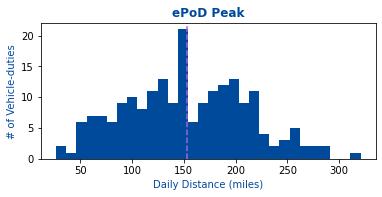

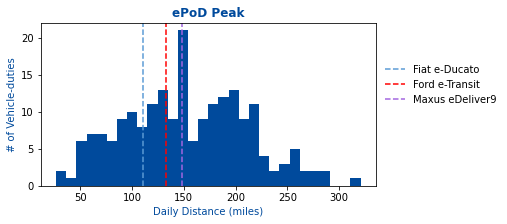

In [158]:
# All histos

fig, ax = plt.subplots(
    1, figsize=(6, 2.5), gridspec_kw={'hspace': 0.5})

ax.set_title(
    title,
    color=fps_colours[0], fontweight='bold')
ax.hist(
    grouped['distance_miles'],
    bins=30,
    color=[fps_colours[0]])

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
ax.set_xlabel('Daily Distance (miles)', color=fps_colours[0])
ax.axvline(x=grouped['distance_miles'].mean(),
           label='Mean', ls='--', color=colors[v])


fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos_FT_2/combined_duties_alloc{alloc['allocation_id']}.png",
    bbox_inches="tight", dpi=300)

# EV feasibility
fig, ax = plt.subplots(
    1, figsize=(6, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    title,
    color=fps_colours[0], fontweight='bold')
ax.hist(
    grouped['distance_miles'],
    bins=30,
    color=[fps_colours[0]])

for v in vehicles:
    ax.axvline(x=range_wltp[v]*XMPG, label=name[v], ls='--', color=colors[v])

ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
ax.set_xlabel('Daily Distance (miles)', color=fps_colours[0])


fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos_FT_2/feasibility{alloc['allocation_id']}.png",
    bbox_inches="tight", dpi=300)

### Charging Profiles

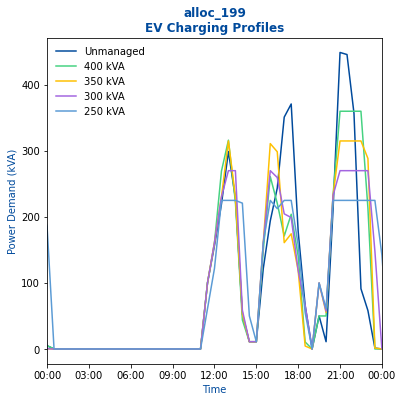

In [64]:
scenarios = 242, 241, 258, 272, 286
profiles = []
cnx = dbh.create_alch_engine()
for s in scenarios:
    profiles_bau = load_charging_profile(s, cnx)
    charge_profiles = profiles_bau.groupby('datetime').sum()['power_demand_kw'].sort_index().rename('bau')
    profiles.append(charge_profiles)
cnx.dispose()
max_demand = [p.max()/0.9 for p in profiles]
labels = ['Unmanaged', '400 kVA', '350 kVA', '300 kVA', '250 kVA']
start = dt.datetime(2022, 3, 22)
name = "alloc_199"
plot_multi_profiles(profiles, start, labels, name)

2022-05-11 11:16:07|DEBUG|1514209953.py(157)|plot_profile|dates: ['2021-10-31T00:00:00.000000000' '2021-10-27T22:00:00.000000000'
 '2021-10-24T23:00:00.000000000']


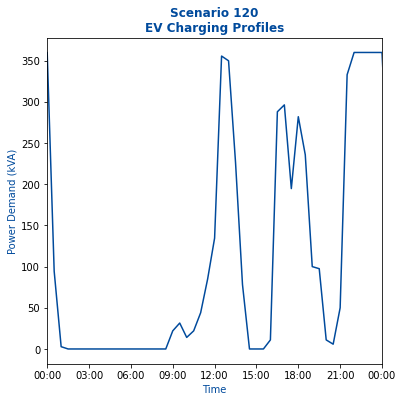

In [70]:
# scenario = 129  # 119, 229, 129
# date = dt.datetime(2021, 9, 10, 7)
# scenario = 229  # 119, 229, 129
# date = dt.datetime(2021, 11, 25)
scenario = 120  # 119, 229, 129
date = dt.datetime(2021, 10, 22)

plot_profile(scenario, date)

### Manage runs

In [55]:
runs = tuple(np.arange(140, 143))
# runs = '(82)'
new_start_run = 163

cnx = dbh.create_alch_engine()
run_table = find_runs(runs, cnx)
run_table['allocation_version'] = 'argos3'
run_table['vehicles'] = '[[33], []]'
run_table['chargers'] = '[11, 50]'
run_table['xmpg_change'] = -30
run_id_diff = run_table['run_id'] - run_table['run_id'].min()
run_table['run_id'] = new_start_run + run_id_diff
dbh.upload_table(run_table, 't_run_allocation')
cnx.dispose()
run_table

2022-05-06 10:16:48|DEBUG|db_handler.py(62)|upload_table|Uploaded to t_run_allocation


,run_id,client_id,allocation_app,allocation_version,sites,start_date,end_date,vehicles,xmpg_change,chargers,route_table,cap_vehicles,mixed_fleet,source,num_v
0,163,2,allocate.py,argos3,[33],2022-02-14,2022-02-21,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],101,None
1,164,2,allocate.py,argos3,[284],2022-03-21,2022-03-28,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],101,None
2,165,2,allocate.py,argos3,[284],2022-03-14,2022-03-21,"[[33], []]",-30,"[11, 50]",t_route_master,False,[],101,None


In [38]:
alloc_ids = tuple(np.arange(126, 225))

try:
    cnx = dbh.create_alch_engine()
    sql_query = f"""SELECT run_id, allocation_id FROM t_allocation WHERE allocation_id IN {alloc_ids} ORDER BY run_id"""
    allocations = pd.read_sql_query(sql_query, cnx)
except (Exception, psycopg2.Error) as error:
    logger.error(f"Error while fetching allocations")
    raise(error)
finally:
    cnx.dispose()
allocations.to_csv('sample/original_run_ids.csv', index=False)

### Shift starts

Text(0.5, 0, 'Time (hours)')

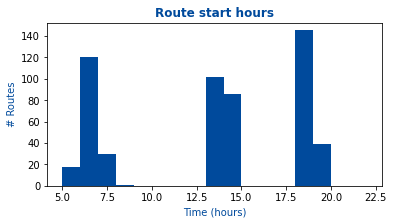

In [44]:
cnx = dbh.create_alch_engine()
site = 284
query = f"SELECT * FROM t_route_master WHERE site_id_start={site}"
routes = pd.read_sql_query(query, cnx)
# routes = routes[routes['departure_time'].dt.date == dt.date(2021, 11, 28)]
hour_starts = (pd.to_datetime(routes['departure_time'])-pd.to_datetime(routes['departure_time'].dt.date)) / np.timedelta64(1, 'h')
fig, ax = plt.subplots(
    1, figsize=(6, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    'Route start hours',
    color=fps_colours[0], fontweight='bold')
ax.hist(
    hour_starts,
    np.arange(5, 23),
    color=[fps_colours[0]])

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# Routes', color=fps_colours[0])
ax.set_xlabel('Time (hours)', color=fps_colours[0])

### Upload EPOD-derived routes

In [71]:
def load_sample_epod(path, site, source, client, start_id):
    try:
        connection, cur = dbh.database_connection('test')
        cols = ['route_id', 'departure_time', 'arrival_time',
                'distance_mileage', 'number_order']
        synth_routes = pd.read_csv(path, index_col=None, usecols=cols)
        synth_routes.rename(columns={
            'distance_mileage': 'distance_miles',
            'route_id': 'client_route_id',
            'departure_time': 'actual_start_time',
            'arrival_time': 'actual_end_time'},
                            inplace=True)
        synth_routes['site_id_start'] = site
        synth_routes['site_id_end'] = site
        synth_routes['source'] = source
        synth_routes['client_id'] = client
        for c in ['actual_start_time', 'actual_end_time']:
            synth_routes[c] = pd.to_datetime(synth_routes[c])
        # query_str = ('SELECT route_id FROM t_route_master ORDER BY route_id DESC LIMIT 1')
        # query_2 = ('SELECT route_id FROM t_telematics ORDER BY route_id DESC LIMIT 1')
        # logger.info('reading formatted routing data from t_routing table')
        # route_id = 1
        # cur.execute(query_str)
        # connection.commit()
        # route_id_routes = cur.fetchall()[0][0]
        # cur.execute(query_2)
        # connection.commit()
        # route_id_tel = cur.fetchall()[0][0]
        # route_id = max(route_id_routes, route_id_tel) + 1
        synth_routes['route_id'] = start_id + np.arange(len(synth_routes))
    except Exception as err:
        raise err
    finally:
        cur.close()
        connection.close()
    return synth_routes


def process_file(path, site, source, client, start_id, comment):
    synth_routes = load_sample_epod(path, site, source, client, start_id)
    synth_routes['comment'] = comment
    dbh.upload_table(synth_routes.drop(columns=['client_route_id']), 't_route_formatted')
    synth_routes.to_csv(f'sample/epod_routes_formatted_{site}.csv')
    return synth_routes['route_id'].max()

comment = "Argos epod historic"

last_id = 168638
path = 'sample/full_routes_epod_2901_NEW.csv'
site = 33
last_id = process_file(path, site, 101, 2, last_id+1, comment)

# path = 'sample/full_routes_epod_2903_NEW.csv'
# site = 284
# last_id = process_file(path, site, 101, 2, last_id+1, comment)

# path = 'sample/full_routes_epod_2797_NEW.csv'
# site = 287
# last_id = process_file(path, site, 101, 2, last_id+1, comment)

In [ ]:
synth_routes = load_sample_epod(path, site, 201, 2, start_id)
synth_routes['comment'] = comment

In [38]:
site = 284
source = 101
try:
    cnx = dbh.create_alch_engine()
    sql_query = f"""SELECT * FROM t_route_formatted WHERE site_id_start = {site} AND source = {source}"""
    routes = pd.read_sql_query(sql_query, cnx)
except (Exception, psycopg2.Error) as error:
    logger.error(f"Error while fetching routes")
    raise(error)
finally:
    cnx.dispose()


In [40]:
routes.rename(columns={
    'actual_start_time': 'departure_time',
    'actual_end_time': 'arrival_time'
}, inplace=True)
cols = ['client_id', 'site_id_start', 'departure_time', 'arrival_time',
        'vehicle_id', 'distance_miles', 'route_id', 'payload', 'number_crates',
        'number_order', 'driving_time', 'site_id_end', 'source']
dbh.upload_table(routes[cols], 't_route_master')

2022-05-06 09:44:39|DEBUG|db_handler.py(62)|upload_table|Uploaded to t_route_master


### Check routes removed

In [36]:
jin_table = pd.read_csv(r'sample/argos3/jins_scenarios_argos3.csv',
                        usecols=['vehicle', 'route_set', 'allocation_id'])
allocations = jin_table['allocation_id']
cnx = dbh.create_alch_engine()
sql_query = f"SELECT allocation_id, vehicle1, vehicle2, num_r, site_id FROM t_allocation WHERE allocation_id IN {tuple(allocations)}"
allocation_table = pd.read_sql_query(sql_query, con=cnx)
jin_table = jin_table.merge(allocation_table, left_on='allocation_id', right_on='allocation_id', how='left')
jin_table.to_csv(r'sample/argos3/jins_scenarios_argos3.csv')